# CCA SSVEP dataset

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack
from scipy import stats, integrate
from scipy import signal
from scipy.signal import butter, lfilter, filtfilt

from sklearn.cross_decomposition import CCA
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline

## Load Data

In [2]:
# load and sort the paths
path = '../data/raw/'
sampling_rate = 128

fnames = glob(path+'*.csv') # get paths and save them
fnames = [ '../data/raw/alebs-record.csv',
 '../data/raw/barlo-record.csv',
 '../data/raw/yagmur-record.csv']
fnames.sort()

In [3]:
electrodes_names = ['Time','AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'label']
aleks2 = {}
aleks2 = pd.read_csv('../data/raw/alebs-2-record.csv', names=electrodes_names)
# aleks2[2000:2100]

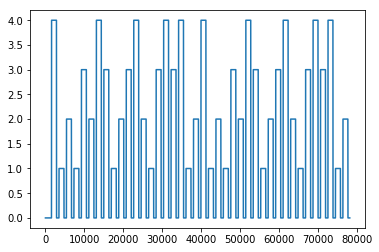

In [4]:
plt.plot(aleks2.label)

## Applying Bandpass Filter on One Channel

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return filtfilt(b, a, data) 

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
aleks2_filt = pd.DataFrame()

for col in aleks2.columns.tolist():
    aleks2_filt[col] = butter_bandpass_filter( aleks2[col], 5, 20, sampling_rate)

aleks2_filt.label = aleks2.label
aleks2_filt.Time = aleks2.Time
aleks2_filt.head(2)

,Time,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,label
0,0.000000,10.215994,10.228524,10.243309,10.297939,10.494405,10.300946,10.452806,10.257092,10.265111,10.114754,10.210481,10.256340,10.173393,10.239801,0
1,0.007812,78.546269,78.628800,78.754730,79.150601,80.692626,79.185494,80.350060,78.843885,78.888736,77.821932,78.559523,78.848381,78.227072,78.725506,0


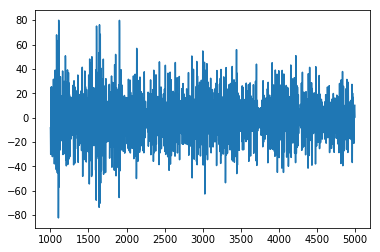

In [7]:
plt.plot(aleks2_filt.AF3[1000:5000]);

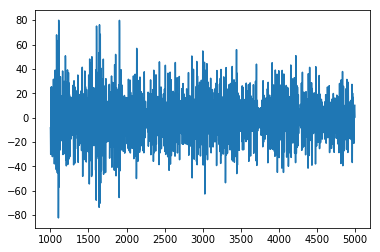

In [8]:
plt.plot(aleks2_filt.AF3[1000:5000]);

## Epochs

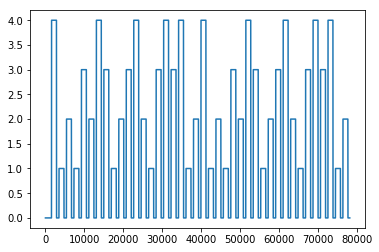

In [9]:
plt.plot(aleks2.label)

### Get Points Needed For Epochs

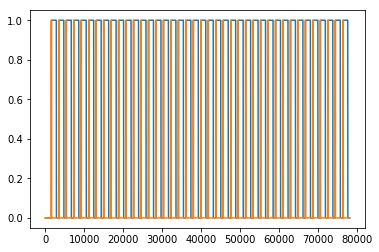

In [10]:
threshold = 0.5

idxOFF = np.argwhere(aleks2.label < threshold)
idxON = np.argwhere(aleks2.label > threshold)


x_alwaysON = np.zeros(len(aleks2.index))
x_alwaysON[idxON] = 1

x_turnON = np.roll(x_alwaysON, 1)
x_turnON = x_alwaysON - x_turnON
x_turnON = np.where(x_turnON > 0, x_turnON, 0)

plt.plot(x_alwaysON)
plt.plot(x_turnON)
plt.show()

In [11]:
y = np.zeros(len(np.argwhere(x_turnON)))
i = 0
for n in np.argwhere(x_turnON):
    y[i] = aleks2.label[n]
    i+=1
y

array([4., 1., 2., 1., 3., 2., 4., 3., 1., 2., 3., 4., 2., 1., 3., 4., 3.,
       4., 1., 2., 4., 1., 2., 1., 3., 2., 4., 3., 1., 2., 3., 4., 2., 1.,
       3., 4., 3., 4., 1., 2.])

### Pick Only Needed Electrodes

In [12]:
picked_electrodes = {'AF3', 'F3', 'AF4', 'F4', 'F7', 'F8'}

data_electr_filt = np.zeros((aleks2_filt.shape[0], len(picked_electrodes)))


for n, elec in enumerate(picked_electrodes):
    data_electr_filt[:,n] = aleks2_filt[elec]

data_electr_filt.shape

(78208, 6)

### Epoching over all data
epochs = num trials x num data points x num electrodes
epochs concat = trials\*electrodes x data points

In [13]:
N_epoch = 700
epochs = np.zeros((len( np.argwhere(x_turnON) ),N_epoch, len(picked_electrodes))) #34x700x4 

for n, i in enumerate(np.argwhere(x_turnON)):  
    epochs[n,:,:] = data_electr_filt[i[0]+400:i[0]+400+N_epoch,:]
    

In [14]:
epochs.shape

(40, 700, 6)

#  Canonical Correlation Analysis (CCA) 
Canonical correlation analysis is a method for exploring the relationships between two multivariate sets of variables (vectors), all measured on the same individual.
    so one of the vectors: our electodes 
    second vector: the sinusoids of the same frequency

### Defining the sinusoids vectors

In [15]:
num_samples = 700
sampling_rate = 128
time = np.arange(0,(num_samples)/sampling_rate, 1/sampling_rate)

base_sin10 =  np.sin(2*np.pi*time*10)
base_sin12 =  np.sin(2*np.pi*time*12)
base_sin15 =  np.sin(2*np.pi*time*15)

### Taking one epoch with 6 electrodes to correlate

In [16]:
X = np.stack(((epochs[0,:,0], epochs[0,:,1], epochs[0,:,2], epochs[0,:,3], epochs[0,:,4], epochs[0,:,5]))).T
np.shape(X)

(700, 6)

### CCA of 3 electrodes

In [29]:
from scipy.linalg import inv, eig

def CCA_corrcoeff(X, Y):
    """Function calculates correlations coeffciencts r"""
    Z = np.column_stack((X, Y,))
    C = np.cov(Z.T)

    sy = np.shape(Y)[1] if Y.ndim > 1 else 1
    sx = np.shape(X)[1] if X.ndim > 1 else 1

    Cxx = C[0:sx, 0:sx] + 10**(-8) * np.eye(sx)
    Cxy = C[0:sx, sx:sx+sy]
    Cyx = Cxy.T
    Cyy = C[sx:sx+sy, sx:sx+sy] + 10**(-8) * np.eye(sy)
    invCyy = inv(Cyy)
    invCxx = inv(Cxx)

    r, Wx = eig( np.dot( np.dot(invCxx, Cxy), np.dot(invCyy, Cyx) ) )
    r = np.real(r)
    r_sqrt = np.sqrt(np.round(r, 7))

    return r, r_sqrt

In [30]:
def calculate_r(X):
    r1, r1_sqrt = CCA_corrcoeff(X, base_sin15)
    r2, r2_sqrt = CCA_corrcoeff(X, base_sin12)
    r3, r3_sqrt = CCA_corrcoeff(X, base_sin10)
    r = np.stack(((r1, r2, r3)))
    r_sqrt = np.stack(((r1_sqrt, r2_sqrt, r3_sqrt)))
    
    return(r, r_sqrt)

In [31]:
r, r_sqrt = calculate_r(X)
np.sum(r_sqrt, axis=1)

array([0.0933879 , 0.16683105, 0.18482208])

In [32]:
n = 2
X = np.stack(((epochs[n,:,0], epochs[n,:,1], epochs[n,:,2], epochs[n,:,3], epochs[n,:,4], epochs[n,:,5]))).T
r, r_sqrt = calculate_r(X)
r_sum = np.max(r_sqrt, axis=1)
print(r_sum)
print(np.argmax(r_sum)+1)

[0.18633545 0.22052143 0.1323756 ]
2


In [33]:
R = np.zeros(len(y))
R_sum = np.zeros((len(y),3))
for n in np.arange(0,len(y)):
    X = np.stack(((epochs[n,:,0], epochs[n,:,1], epochs[n,:,2], epochs[n,:,3], epochs[n,:,4], epochs[n,:,5]))).T
    r, r_sqrt = calculate_r(X)
    
    R_sum[n] = np.max(r_sqrt, axis=1)
    R[n] = np.argmax(np.max(r_sqrt, axis=1))

In [45]:
# our results
R+2

array([3., 3., 3., 2., 2., 3., 3., 3., 2., 4., 2., 3., 2., 2., 2., 3., 2.,
       3., 3., 3., 3., 3., 2., 2., 2., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
       2., 3., 2., 3., 4., 4.])

In [35]:
# original labels
y-1

array([3., 0., 1., 0., 2., 1., 3., 2., 0., 1., 2., 3., 1., 0., 2., 3., 2.,
       3., 0., 1., 3., 0., 1., 0., 2., 1., 3., 2., 0., 1., 2., 3., 1., 0.,
       2., 3., 2., 3., 0., 1.])

### Examples of results

In [36]:
R_sum[0:5]

array([[0.21009522, 0.35818333, 0.12895232],
       [0.19351873, 0.28239281, 0.18411491],
       [0.18633545, 0.22052143, 0.1323756 ],
       [0.27320267, 0.23021468, 0.19668528],
       [0.48523819, 0.16198025, 0.20134622]])

In [41]:
R[0:5]+2

array([3., 3., 3., 2., 2.])

In [42]:
y[0:5]


array([4., 1., 2., 1., 3.])

In [43]:
# diff
R - y

array([-3.,  0., -1., -1., -3., -1., -3., -2., -1.,  0., -3., -3., -2.,
       -1., -3., -3., -3., -3.,  0., -1., -3.,  0., -2., -1., -3., -2.,
       -3., -3.,  0., -1., -3., -3., -1., -1., -3., -3., -3., -3.,  1.,
        0.])

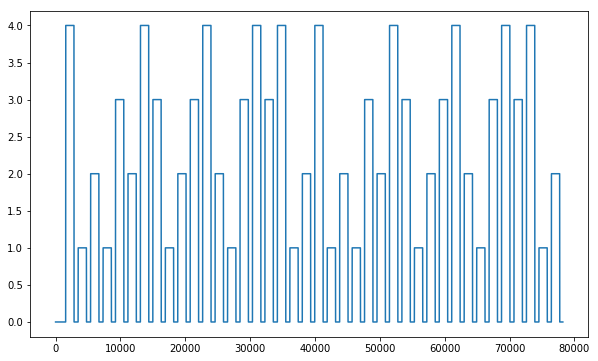

In [40]:
plt.figure(figsize=(10,6))
plt.plot(aleks2.label);